In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import nltk
from sklearn import metrics
import util
from featurize import add_features

%matplotlib inline

# Gather and Manipulate Data

In [2]:
lines = util.parse_training_data()
for line in lines:
    line = add_features(line)

In [3]:
df = pd.DataFrame.from_dict(lines)

In [4]:
df.shape

(758, 13)

### Removing columns not used in classifier

In [5]:
del df["?"]
del df["chinese"]
del df["human"]
del df["h_tree"]
del df["q_tree"]

### Converting labels to numbers

In [6]:
label_map = {"H" : 0, "M" : 1}
df["label"] = df["label"].map(label_map)

In [7]:
df.head(10)

,bleu,chrf,gleu,human_to_trans_ratio,label,original_to_trans_ratio,token_ratio,tree_height_ratio
0,0.3125,0.577535,0.173913,0.903614,0,0.373494,0.887324,1.714286
1,0.6531,0.756146,0.427711,0.932271,0,0.513944,0.973509,1.071429
2,0.3784,0.436345,0.112676,1.081967,1,0.606557,1.194716,1.000000
3,0.3646,0.424499,0.171233,1.264368,1,0.609195,1.127100,1.800000
4,0.7778,0.850340,0.409091,0.898876,0,0.539326,1.100000,0.916667
5,0.7368,0.633663,0.371429,1.050505,0,0.606061,1.061728,1.444444
6,0.6364,0.703791,0.358824,0.857143,0,0.444898,0.991662,1.000000
7,0.6000,0.792161,0.395604,0.803213,0,0.449799,1.061166,0.928571
8,0.5273,0.640663,0.247706,0.803333,0,0.456667,1.003584,1.230769
9,0.5128,0.643032,0.280000,0.953704,0,0.449074,1.006681,1.352941


In [8]:
# Make sure balanced results
num_true = len(df.loc[df["label"] == 1])
num_false = len(df.loc[df["label"] == 0])
print("Number of Machine Translations: {0} ({1:2.2f}%)".format(num_true, (num_true / (num_true + num_false)) * 100.0))
print("Number of Human Translations: {0} ({1:2.2f}%)".format(num_false, (num_false / (num_true + num_false)) * 100.0))

Number of Machine Translations: 354 (46.70%)
Number of Human Translations: 404 (53.30%)


## Corelation Matrix

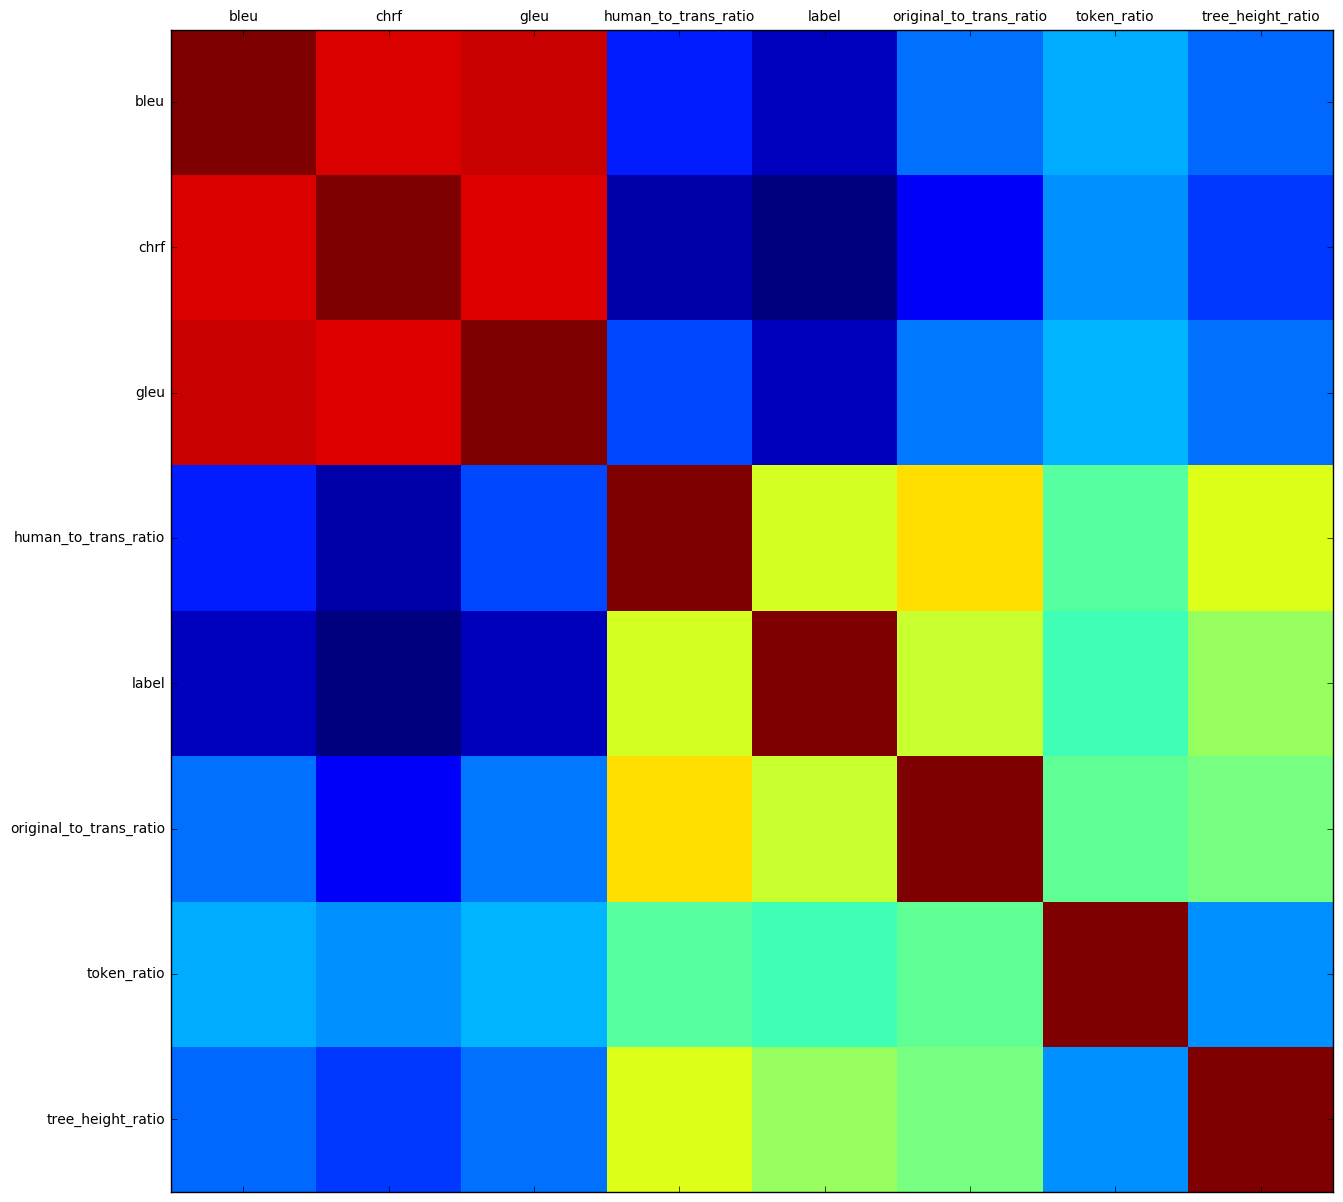

In [9]:
size = 15
corr = df.corr() # data frame correlation function
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr) # color code the rectangles by correlation value
plt.xticks(range(len(corr.columns)), corr.columns) # draw x tick marks
plt.yticks(range(len(corr.columns)), corr.columns) # draw y tick marks
plt.show()

### Dropping unwanted features

In [10]:
del df["bleu"]

### Spliting the data
80% for training, 20% for testing

In [11]:
from sklearn.cross_validation import train_test_split

feature_col_names = list(df.columns.values)
feature_col_names.remove('label')

predicted_class_names = ['label']

In [12]:
X = df[feature_col_names].values
y = df[predicted_class_names].values
split_test_size = 0.20

# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = split_test_size, random_state = 42)

## Support Vector Machine

In [13]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(X_train, y_train.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Performance on Training Data

In [14]:
# predict values using the training data
svc_predict_train = svc_model.predict(X_train)

print("Accurary: {0:.4f}".format(metrics.accuracy_score(y_train, svc_predict_train)))

Accurary: 0.7690


### Performance on Testing Data

In [15]:
svc_predict_test = svc_model.predict(X_test)

print("Accuracy: {0:.4f}".format(metrics.accuracy_score(y_test, svc_predict_test)))

Accuracy: 0.7961


#### Metrics

In [16]:
print("Confussion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, svc_predict_test, labels=[1, 0])))
print()

print("Classification Report")
print(metrics.classification_report(y_test, svc_predict_test, labels=[1,0]))

Confussion Matrix
[[54 17]
 [14 67]]

Classification Report
             precision    recall  f1-score   support

          1       0.79      0.76      0.78        71
          0       0.80      0.83      0.81        81

avg / total       0.80      0.80      0.80       152



## Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

# create Gaussian Naive Bayes model object and train it with the data
nb_model = GaussianNB()

nb_model.fit(X_train, y_train.ravel())

GaussianNB()

### Performance on Training Data

In [18]:
# predict values using the training data
nb_predict_train = nb_model.predict(X_train)

print("Accurary: {0:.4f}".format(metrics.accuracy_score(y_train, nb_predict_train)))

Accurary: 0.7855


### Performance on Testing Data

In [19]:
# predict values using the testing data
nb_predict_test = nb_model.predict(X_test)

print("Accurary: {0:.4f}".format(metrics.accuracy_score(y_test, nb_predict_test)))

Accurary: 0.7697


#### Metrics

In [20]:
print("Confussion Matrix")

# Note the use of label for set 1=True to upper left and 0=False to lower right
print("{0}".format(metrics.confusion_matrix(y_test, nb_predict_test, labels=[1, 0])))
print()

print("Classification Report")
print(metrics.classification_report(y_test, nb_predict_test, labels=[1, 0]))

Confussion Matrix
[[50 21]
 [14 67]]

Classification Report
             precision    recall  f1-score   support

          1       0.78      0.70      0.74        71
          0       0.76      0.83      0.79        81

avg / total       0.77      0.77      0.77       152



## Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10)

rf_model.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Performance on Training Data

In [22]:
# predict values using the training data
rf_predict_train = rf_model.predict(X_train)

print("Accurary: {0:.4f}".format(metrics.accuracy_score(y_train, rf_predict_train)))

Accurary: 0.9785


### Performance on Testing Data

In [23]:
# predict values using the testing data
rf_predict_test = rf_model.predict(X_test)

print("Accurary: {0:.4f}".format(metrics.accuracy_score(y_test, rf_predict_test)))

Accurary: 0.7303


#### Metrics

In [24]:
print("Confussion Matrix")

# Note the use of label for set 1=True to upper left and 0=False to lower right
print("{0}".format(metrics.confusion_matrix(y_test, rf_predict_test, labels=[1, 0])))
print()

print("Classification Report")
print(metrics.classification_report(y_test, rf_predict_test, labels=[1, 0]))

Confussion Matrix
[[46 25]
 [16 65]]

Classification Report
             precision    recall  f1-score   support

          1       0.74      0.65      0.69        71
          0       0.72      0.80      0.76        81

avg / total       0.73      0.73      0.73       152

